## Monthly Car Sales

1. Análisis Exploratorio:
Describir la serie de tiempo y visualizarla.

              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000


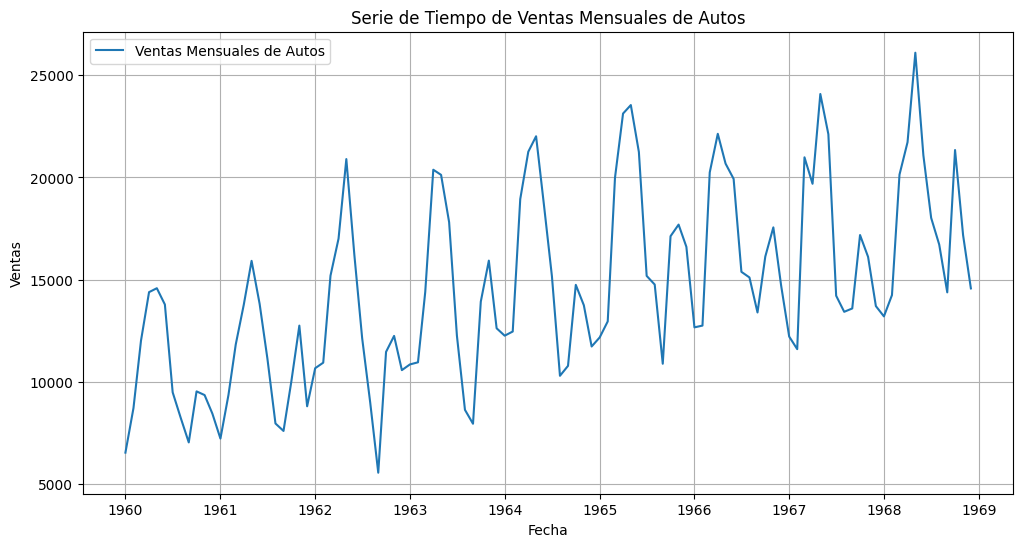

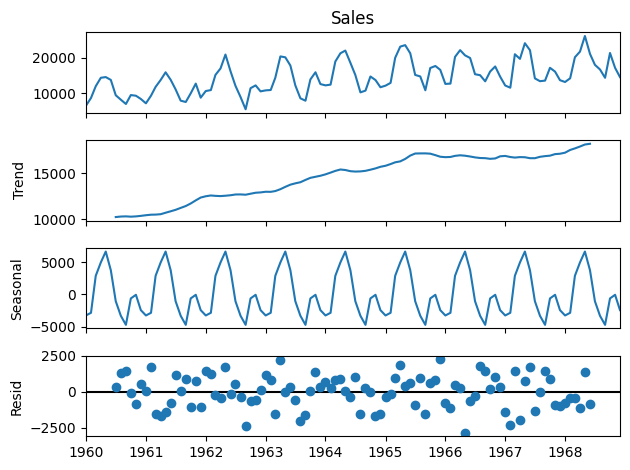

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv("monthly-car-sales.csv")

# Convertir la columna 'Month' en tipo datetime
df['Month'] = pd.to_datetime(df['Month'])

# Establecer 'Month' como índice
df.set_index('Month', inplace=True)

# Descripción básica de la serie de tiempo
print(df.describe())

# Visualización de la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Ventas Mensuales de Autos')
plt.title('Serie de Tiempo de Ventas Mensuales de Autos')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

# Descomposición de la serie de tiempo (tendencia, estacionalidad y residuo)
decomposition = sm.tsa.seasonal_decompose(df['Sales'], model='additive')
decomposition.plot()
plt.show()


2. Promedios: Aplicar métodos de promedios y comparar los resultados con el conjunto original.

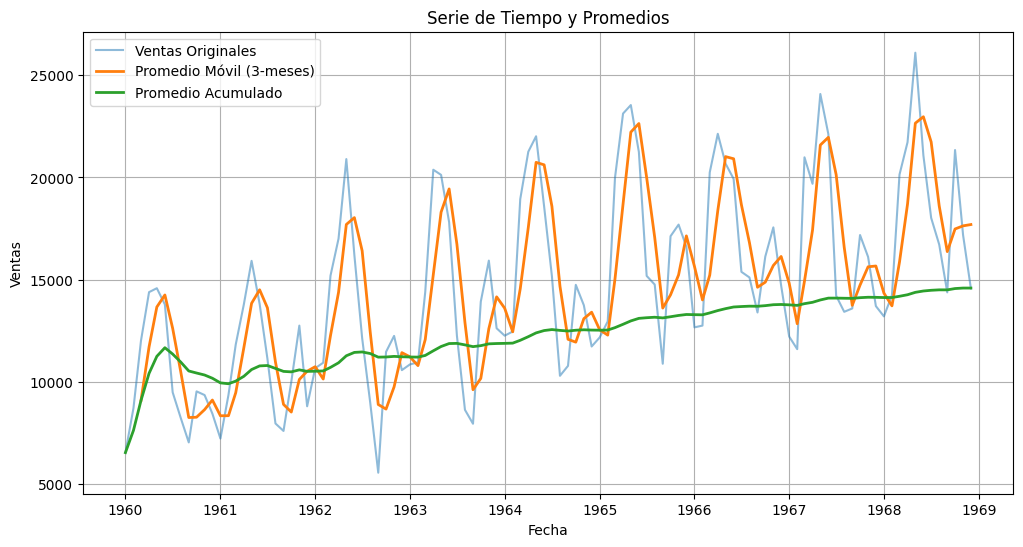

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv("monthly-car-sales.csv")

# Convertir la columna 'Month' en tipo datetime
df['Month'] = pd.to_datetime(df['Month'])

# Establecer 'Month' como índice
df.set_index('Month', inplace=True)

# Calcular el promedio móvil (Moving Average) con una ventana de 3 meses
window_size = 3
rolling_mean = df['Sales'].rolling(window=window_size).mean()

# Calcular el promedio acumulado (Cumulative Average)
cumulative_average = df['Sales'].expanding().mean()

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Ventas Originales', alpha=0.5)
plt.plot(df.index, rolling_mean, label=f'Promedio Móvil ({window_size}-meses)', linewidth=2)
plt.plot(df.index, cumulative_average, label='Promedio Acumulado', linewidth=2)
plt.title('Serie de Tiempo y Promedios')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


3. SARIMA: Identificar parámetros y ajustar un modelo SARIMA.

c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\L

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -837.873
Date:                            Fri, 01 Sep 2023   AIC                           1683.747
Time:                                    16:56:28   BIC                           1693.962
Sample:                                01-01-1960   HQIC                          1687.875
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2168      0.118      1.841      0.066      -0.014       0.448
ma.L1         -0.8911      0.063   

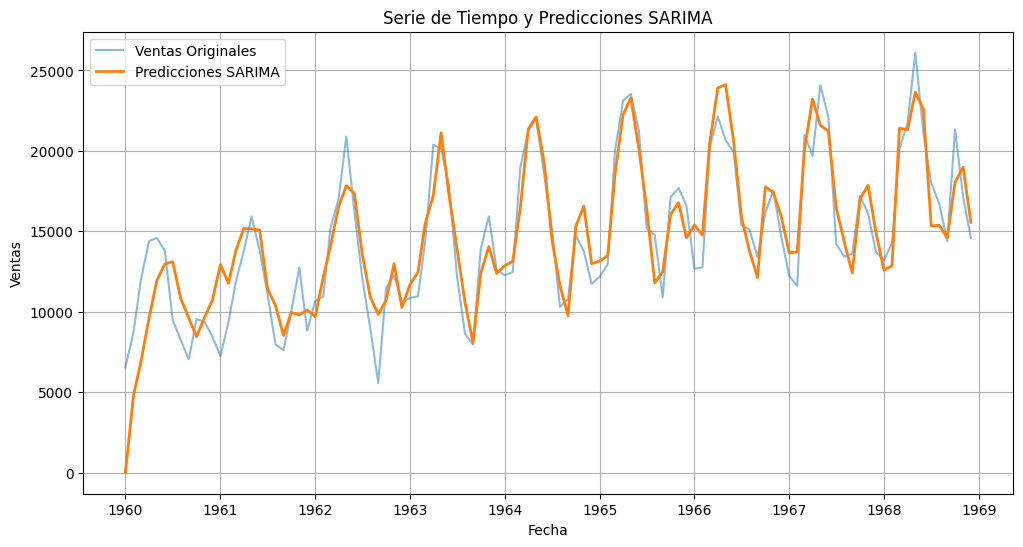

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv("monthly-car-sales.csv")

# Convertir la columna 'Month' en tipo datetime
df['Month'] = pd.to_datetime(df['Month'])

# Establecer 'Month' como índice
df.set_index('Month', inplace=True)

# Identificar los órdenes del modelo SARIMA (p, d, q, P, D, Q, S)
# Estos son parámetros que debes ajustar según tu serie de tiempo específica
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
S = 12  # Estacionalidad mensual (12 meses en un año)

# Crear una lista de combinaciones de parámetros SARIMA
from itertools import product
param_combinations = list(product(p, d, q, P, D, Q, [S]))

# Elegir el mejor modelo SARIMA utilizando criterios como AIC o BIC
best_aic = float("inf")
best_model = None

for param in param_combinations:
    try:
        model = sm.tsa.SARIMAX(df['Sales'], order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], param[6]))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = model
    except:
        continue

# Ajustar el mejor modelo SARIMA identificado
final_model = best_model.fit()

# Resumen del modelo
print(final_model.summary())

# Visualización de la serie de tiempo y predicciones del modelo SARIMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Ventas Originales', alpha=0.5)
plt.plot(df.index, final_model.fittedvalues, label='Predicciones SARIMA', linewidth=2)
plt.title('Serie de Tiempo y Predicciones SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


4. Alisamiento Exponencial: Aplicar diferentes métodos de alisamiento exponencial y comparar.

c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kenic\AppData\Local\Temp\ipykernel_10384\1904886386.py:19: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  des_model = sm.tsa.ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12, damped=True)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kenic\AppData\Local\Programs\Python\Python311\Lib

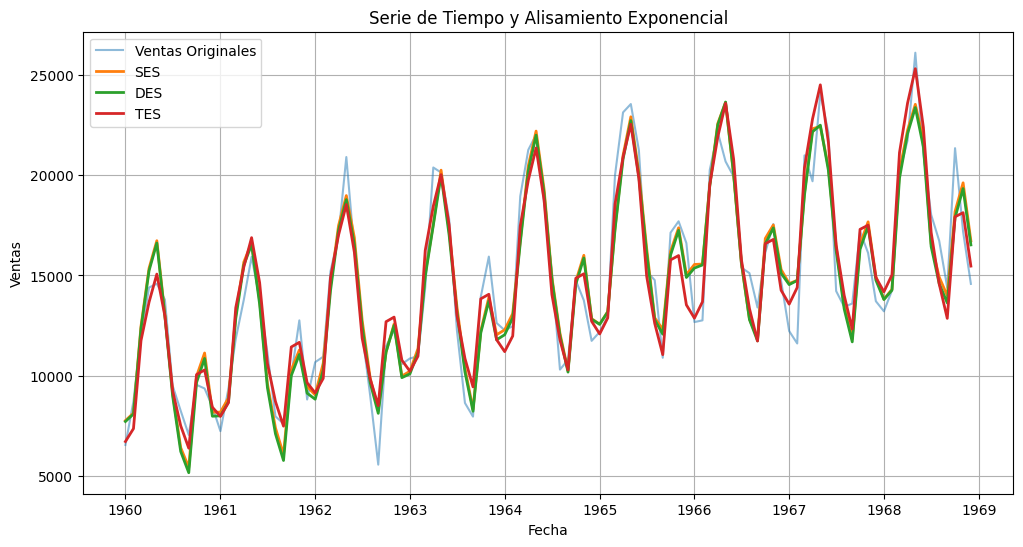

SES - Estadísticas de ajuste:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                      221687984.491
Optimized:                         True   AIC                           1601.742
Trend:                         Additive   BIC                           1644.656
Seasonal:                      Additive   AICC                          1609.428
Seasonal Periods:                    12   Date:                 Fri, 01 Sep 2023
Box-Cox:                          False   Time:                         16:59:55
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2527564                alpha                 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv("monthly-car-sales.csv")

# Convertir la columna 'Month' en tipo datetime
df['Month'] = pd.to_datetime(df['Month'])

# Establecer 'Month' como índice
df.set_index('Month', inplace=True)

# Aplicar Alisamiento Exponencial Simple (SES)
ses_model = sm.tsa.ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12)
ses_results = ses_model.fit()

# Aplicar Alisamiento Exponencial Doble (DES)
des_model = sm.tsa.ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12, damped=True)
des_results = des_model.fit()

# Aplicar Alisamiento Exponencial Triple (TES)
tes_model = sm.tsa.ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12, damped=True, use_boxcox=True)
tes_results = tes_model.fit()

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Ventas Originales', alpha=0.5)
plt.plot(df.index, ses_results.fittedvalues, label='SES', linewidth=2)
plt.plot(df.index, des_results.fittedvalues, label='DES', linewidth=2)
plt.plot(df.index, tes_results.fittedvalues, label='TES', linewidth=2)
plt.title('Serie de Tiempo y Alisamiento Exponencial')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir estadísticas de ajuste
print("SES - Estadísticas de ajuste:")
print(ses_results.summary())

print("\nDES - Estadísticas de ajuste:")
print(des_results.summary())

print("\nTES - Estadísticas de ajuste:")
print(tes_results.summary())


5. Prophet: Utilizar Prophet para modelar la serie de tiempo.

In [13]:
!conda install -c conda-forge fbprophet

"conda" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv("monthly-car-sales.csv")

# Renombrar las columnas para que coincidan con las necesidades de Prophet
df.rename(columns={"Month": "ds", "Sales": "y"}, inplace=True)

# Crear un objeto Prophet y ajustar el modelo
model = Prophet(seasonality_mode="additive")
model.fit(df)

# Crear un DataFrame para futuras fechas
future = model.make_future_dataframe(periods=12, freq="M")  # Proyectar 12 meses adicionales

# Realizar las predicciones
forecast = model.predict(future)

# Visualizar las predicciones
fig = model.plot(forecast)
plt.title('Predicciones de Prophet para Ventas Mensuales de Autos')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()


ModuleNotFoundError: No module named 'fbprophet'